In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import xgboost
from xgboost import XGBClassifier
xgboost.set_config(verbosity=0)
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sklearn
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [4]:
renamedf = pd.read_csv('../input/renamed.csv')
renamedf.drop(columns=['Unnamed: 0'], inplace = True)
renamedf

,Age,Gender,BMI,Presence of Symptoms,Fever,Cough,Breathlessness,Travel History,Temp,SpO2,...,Potassium,Chloride,Total Bilirubin,Direct Bilirubin,SGOT,SGPT,Total proteins,Albumin,Alkaline Phosphatase,C-Reactive Proteins
0,53,1,22.5,1,1,1,1,0,96.8,99,...,4.8,108.0,0.5,0.2,81.3,70.0,5.9,3.8,44.1,58.10
1,26,0,25.7,0,0,0,0,0,98.7,98,...,4.1,108.0,0.3,0.1,22.2,14.8,6.6,3.9,58.5,3.66
2,28,1,22.2,0,0,0,0,0,98.4,98,...,18.1,1.1,0.8,0.3,19.3,12.8,7.0,4.2,86.0,10.17
3,73,1,21.5,1,1,1,1,0,98.0,98,...,4.2,104.0,2.4,1.2,59.0,47.9,6.3,3.7,120.0,168.90
4,49,1,27.4,1,1,1,0,0,101.0,98,...,3.8,92.0,4.2,2.1,44.6,55.5,5.9,3.1,177.0,164.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,53,1,27.2,1,1,1,1,0,98.9,96,...,2.9,97.0,1.4,0.5,43.8,38.8,6.2,3.7,73.3,127.60
171,33,1,26.0,1,1,1,1,0,99.3,98,...,4.2,106.0,0.5,0.2,80.6,42.6,6.6,3.8,57.4,138.15
172,70,1,21.4,1,1,0,1,0,98.3,99,...,4.2,106.0,1.8,0.6,77.0,27.9,5.9,3.3,60.1,143.00
173,65,0,22.4,1,0,1,1,0,98.9,97,...,3.8,110.0,1.2,0.6,56.2,43.2,5.6,3.4,216.0,124.00


In [5]:
X = renamedf.drop(['Outcome','qSOFA score'],axis=1)
Y = renamedf['Outcome']

In [9]:
renamedf[['Outcome']].value_counts()

Outcome
0          151
1           24
dtype: int64

In [9]:
from scipy import interp
def nestedcv(pipeline,param_grid, X, Y):
    
    
    f1 = [0]*7
    roc = [0]*7
    prec = [0]*7
    rec = [0]*7
    acc = [0]*7
    
    
    cv_outer = KFold(n_splits=7, shuffle=True)
    i = 0
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    
    for train_ix, test_ix in cv_outer.split(X):
        
        print(i+1)
        
        X_train = X.iloc[train_ix]
        X_test =  X.iloc[test_ix]
        y_train = Y.iloc[train_ix]
        y_test =  Y.iloc[test_ix]
        scaler = MinMaxScaler()
        
        model = ExtraTreesClassifier()
        model.fit(scaler.fit_transform(X_train),y_train)

        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
        x = feat_importances.nlargest(5)
        features = np.array(x.index)
        print(*features+',')

        gs = GridSearchCV(estimator=pipeline, param_grid = param_grid,
                     cv = 6, scoring = 'f1', n_jobs = -1, refit = True)
        
        result = gs.fit(X_train[features],y_train)
        print(result.best_params_)
        best_model = result.best_estimator_
        
        best_model.fit(X_train[features],y_train)
        y_hat = best_model.predict(X_test[features])
        f1[i] = metrics.f1_score(y_test, y_hat)
        prec[i] = metrics.precision_score(y_test, y_hat)
        rec[i] = metrics.recall_score(y_test,y_hat)
        acc[i] = metrics.accuracy_score(y_test,y_hat)
        
    
        viz = metrics.plot_roc_curve(best_model, X_test[features], y_test,
                             name='ROC fold {}'.format(i+1),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        i+=1
        print()
        
        
        if i==6:
            cf_matrix = confusion_matrix(y_test, y_hat)
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
         
    arr = [np.mean(acc),np.mean(f1),mean_auc,np.mean(prec),np.mean(rec)]
    return arr, mean_fpr, mean_tpr, cf_matrix

1
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Total proteins,
{'logisticregression__C': 300, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}

2
Respiratory rate(breaths per minute), Breathlessness, C-Reactive Proteins, Age, Urea,
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}

3
Respiratory rate(breaths per minute), Breathlessness, C-Reactive Proteins, Age, Total proteins,
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}

4
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC Count, Age,
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

5
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC Count, Platelet count,
{'logisticregression__C': 30, 'logisticregression__penalty': 'l2', 'logist

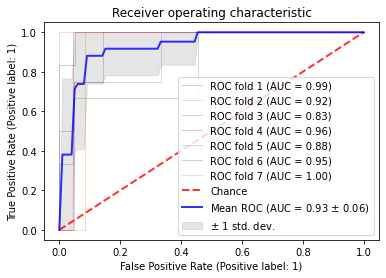

[0.8914285714285715,
 0.5197278911564626,
 0.9309764309764309,
 0.6904761904761905,
 0.4880952380952381]

In [15]:
# Pipeline created using Logistic Regression and MinMaxScaler
pipeline = make_pipeline(MinMaxScaler(),LogisticRegression(max_iter=10000))

param_grid = {'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
'logisticregression__penalty' : ['l2'],
'logisticregression__C' : [300, 100, 30, 10, 3, 1.0, 0.3, 0.1, 0.03, 0.01]} 

lg, lr_fpr, lr_tpr, cf_lr = nestedcv(pipeline,param_grid,X,Y)
lg

1
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Alkaline Phosphate,
{'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 50, 'randomforestclassifier__n_estimators': 400}

2
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 100, 'randomforestclassifier__n_estimators': 700}

3
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 50, 'randomforestclassifier__n_estimators': 700}

4
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC Count, Age,
{'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 100, 'randomforestclassifier__n_estimators': 700}

5
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC 

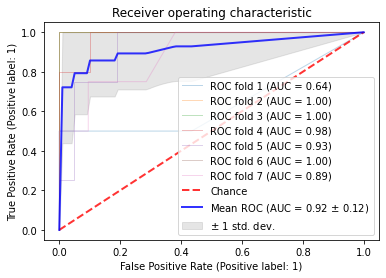

[0.9257142857142856,
 0.6998144712430427,
 0.917120225453559,
 0.8095238095238094,
 0.6738095238095239]

In [16]:
# Pipeline created using Random Forest Classifier and MinMaxScaler
pipeline = make_pipeline(MinMaxScaler(),
                         RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [400, 700],
    'randomforestclassifier__max_depth': [15,20],
    'randomforestclassifier__max_leaf_nodes': [50, 100]
}

rf, fpr_rf, tpr_rf, cf_rf = nestedcv(pipeline,param_grid,X,Y)
rf

1
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Urea,
{'mlpclassifier__activation': 'logistic', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__solver': 'lbfgs'}

2
Respiratory rate(breaths per minute), Breathlessness, C-Reactive Proteins, Age, TLC Count,
{'mlpclassifier__activation': 'logistic', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'lbfgs'}

3
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__solver': 'lbfgs'}

4
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'mlpclassifier__activation': 'relu', 'mlpclassifier

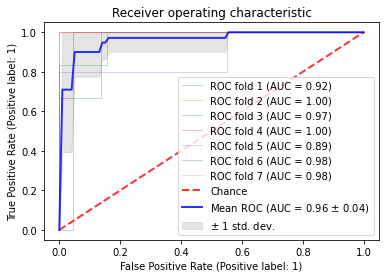

[0.9428571428571428,
 0.7917748917748917,
 0.9618085618085619,
 0.8476190476190476,
 0.7761904761904762]

In [12]:
# Pipeline created using MLP Classifier and MinMaxScaler
pipeline = make_pipeline(MinMaxScaler(),
                         MLPClassifier(max_iter=5000))

pipeline.get_params().keys()
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,)],
    'mlpclassifier__activation': ['relu','logistic'],
    'mlpclassifier__solver': ['lbfgs'],
    'mlpclassifier__alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

mlp, fpr_mlp, tpr_mlp, cf_mlp = nestedcv(pipeline,param_grid,X,Y)
mlp

1
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC Count, Urea,
{'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.7}

2
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, TLC Count, Age,
{'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.7}

3
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.8}

4
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Urea,
{'

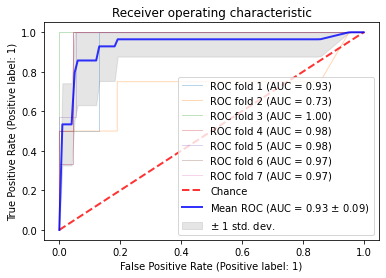

[0.9428571428571428,
 0.7692022263450834,
 0.9339897115871143,
 0.869047619047619,
 0.7482993197278912]

In [17]:
# Pipeline created using XGBoost and MinMaxScaler
pipeline = make_pipeline(MinMaxScaler(),
                         XGBClassifier(use_label_encoder=False))

param_grid = {
    'xgbclassifier__n_estimators': [400, 700],
    'xgbclassifier__colsample_bytree': [0.7, 0.8],
    'xgbclassifier__max_depth': [15,20],
    'xgbclassifier__reg_alpha': [1.1, 1.2],
    'xgbclassifier__reg_lambda': [1.1, 1.2],
    'xgbclassifier__subsample': [0.7, 0.8]
}
xgb, fpr_xgb, tpr_xgb, cf_xgb = nestedcv(pipeline,param_grid,X,Y)
xgb

1
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'svc__C': 10, 'svc__gamma': 3, 'svc__kernel': 'rbf'}

2
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Urea,
{'svc__C': 300, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

3
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'svc__C': 10, 'svc__gamma': 3, 'svc__kernel': 'rbf'}

4
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'svc__C': 30, 'svc__gamma': 3, 'svc__kernel': 'poly'}

5
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, TLC Count,
{'svc__C': 300, 'svc__gamma': 0.3, 'svc__kernel': 'rbf'}

6
Respiratory rate(breaths per minute), Breathlessness, C-Reactive Proteins, TLC Count, Age,
{'svc__C': 3, 'svc__gamma': 3, 'svc__kernel': 'rbf'}

7
Respiratory rate(breaths per minute), C-Reactive Proteins, Breathlessness, Age, Total proteins,
{'svc__C': 300,

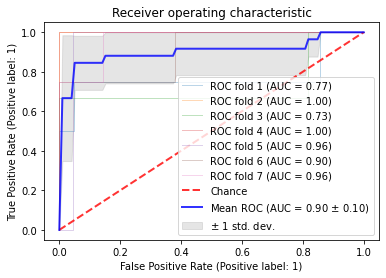

[0.9485714285714285,
 0.7931972789115648,
 0.9005531505531504,
 0.869047619047619,
 0.7738095238095237]

In [19]:
# Pipeline created using SVC and MinMaxScaler
pipeline = make_pipeline(MinMaxScaler(),
                         SVC(probability=True))

param_grid = {'svc__C': [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 
              'svc__gamma': [3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001],
              'svc__kernel': ['rbf','linear','sigmoid','poly']} 


svc, fpr_svc, tpr_svc, cf_svc = nestedcv(pipeline,param_grid,X,Y)
svc


In [20]:
headings = ['Model','Accuracy Score','F1 Score','ROC AUC Score','Precision','Recall']
data = [['Logistic Regression', lg[0],lg[1], lg[2], lg[3], lg[4] ], 
['Support Vector Machine', svc[0], svc[1], svc[2],svc[3],svc[4]],
['XGBoost',xgb[0],xgb[1],xgb[2],xgb[3],xgb[4]],
['Random Forest',rf[0],rf[1],rf[2],rf[3],rf[4]],
['Multi-Layer Perceptron',mlp[0],mlp[1],mlp[2],mlp[3], mlp[4]]]

df = pd.DataFrame(data, columns = headings)
df.to_csv('results.csv')
df

,Model,Accuracy Score,F1 Score,ROC AUC Score,Precision,Recall
0,Logistic Regression,0.891429,0.519728,0.930976,0.690476,0.488095
1,Support Vector Machine,0.948571,0.793197,0.900553,0.869048,0.773810
2,XGBoost,0.942857,0.769202,0.933990,0.869048,0.748299
3,Random Forest,0.925714,0.699814,0.917120,0.809524,0.673810
4,Multi-Layer Perception,0.942857,0.791775,0.961809,0.847619,0.776190


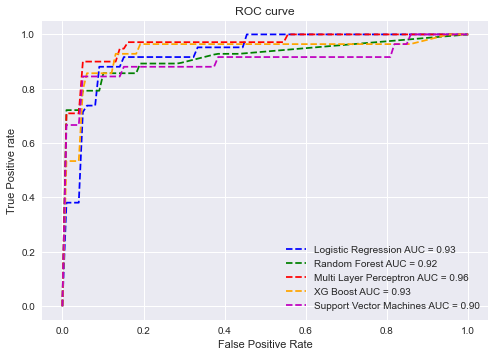

In [30]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.plot(lr_fpr, lr_tpr, linestyle='--',color='blue', label='Logistic Regression AUC = 0.93')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='green', label='Random Forest AUC = 0.92')
plt.plot(fpr_mlp, tpr_mlp, linestyle='--',color='red', label='Multi Layer Perceptron AUC = 0.96')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='orange', label='XG Boost AUC = 0.93')
plt.plot(fpr_svc, tpr_svc, linestyle='--',color='m', label='Support Vector Machines AUC = 0.90')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show()

Text(0.5, 7.0, 'Predicted label')

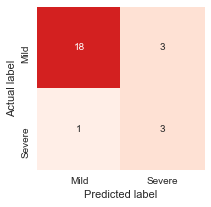

In [22]:
import seaborn as sns
plt.figure
fig, ax = plt.subplots(figsize=(3,3)) 

sns.heatmap(cf_lr, cmap="Reds", annot=True, vmin = 0, vmax = 25, ax= ax,cbar=False)

ax.set_xticklabels(["Mild","Severe"])
ax.set_yticklabels(["Mild","Severe"])

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 7.0, 'Predicted label')

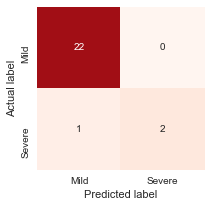

In [23]:
import seaborn as sns
plt.figure
fig, ax = plt.subplots(figsize=(3,3)) 

sns.heatmap(cf_rf, cmap="Reds", annot=True, vmin = 0, vmax = 25, ax= ax,cbar=False)

ax.set_xticklabels(["Mild","Severe"])
ax.set_yticklabels(["Mild","Severe"])

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 7.0, 'Predicted label')

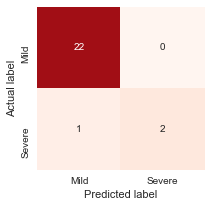

In [24]:
import seaborn as sns
plt.figure
fig, ax = plt.subplots(figsize=(3,3)) 

sns.heatmap(cf_mlp, cmap="Reds", annot=True, vmin = 0, vmax = 25, ax= ax,cbar=False)

ax.set_xticklabels(["Mild","Severe"])
ax.set_yticklabels(["Mild","Severe"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 7.0, 'Predicted label')

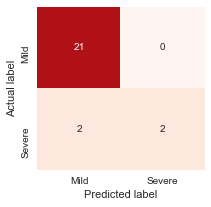

In [25]:
import seaborn as sns
plt.figure
fig, ax = plt.subplots(figsize=(3,3)) 

sns.heatmap(cf_svc, cmap="Reds", annot=True, vmin = 0, vmax = 25, ax= ax,cbar=False)

ax.set_xticklabels(["Mild","Severe"])
ax.set_yticklabels(["Mild","Severe"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 7.0, 'Predicted label')

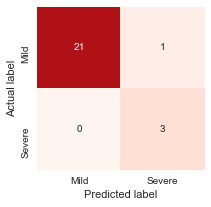

In [26]:
import seaborn as sns
plt.figure
fig, ax = plt.subplots(figsize=(3,3)) 

sns.heatmap(cf_xgb, cmap="Reds", annot=True, vmin = 0, vmax = 25, ax= ax,cbar=False)

ax.set_xticklabels(["Mild","Severe"])
ax.set_yticklabels(["Mild","Severe"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')